<center><h1><u>Abalone age prediction system</u></h1></center>

<img src='static/abalone.jpg' style="width:250px; height:250px; float:right"/>

## Problem statement
Typically, the age of an abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope.This process is tedious and time-consuming.<br>
<b>Predict the age of abalone from physical measurements.</b>



## Dataset information 
- 8 attributes
- 4177 instances

`Sex`: nominal - M (male), F (female), I (infant)

`Length`: continuous - longest shell measurement (in mm)

`Diameter`: continuous - measurement perpendicular to legnth (in mm)

`Height`: continuous - with meat in shell (in mm)

`Whole weight`: continuous - the whole abalone (in grams)

`Shucked weight`: continuous - weight of the meat (in grams)

`Viscera weight`: continuous - gut weight after bleeding (in grams)

`Shell weight`: continuous - after being dried (in grams)

`Rings`: integer - +1.5 gives the age in years

Dataset source : http://archive.ics.uci.edu/ml/datasets/Abalone

## 1. Importing modules

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pickle
import warnings

def evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test):
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    y_cv_preds = model.predict(X_cv)
    
    train_error = np.sqrt(mean_squared_error(y_train, y_train_preds))
    test_error =  np.sqrt(mean_squared_error(y_test, y_test_preds))
    cv_error =  np.sqrt(mean_squared_error(y_cv, y_cv_preds))
    return train_error, cv_error, test_error   

warnings.filterwarnings('ignore')
sns.set()

## 2. Loading dataset

In [187]:
data = pd.read_csv('abalone.data', header=None, index_col=False)

data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

data['age'] = data.rings + 1.5 #add target(age) to dataset [rings + 1.5 = age ]

data.drop('rings', axis=1, inplace=True) #remove rings variable
data.sample(5)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
2528,F,0.60,0.475,0.135,1.4405,0.5885,0.1910,0.3175,10.5
1258,I,0.43,0.315,0.095,0.3780,0.1750,0.0800,0.1045,9.5
2322,M,0.53,0.435,0.135,0.7365,0.3275,0.1315,0.2200,13.5
1134,F,0.57,0.445,0.145,0.8775,0.4120,0.2170,0.2200,9.5
2966,M,0.67,0.540,0.175,1.4820,0.7390,0.2925,0.3650,11.5


In [188]:
X = data.drop('age', axis=1)
y = data.age

## 3. Exploratory data analysis

#### 3a. Missing values

In [189]:
missing_values = data.isnull().sum().sort_values(ascending = False)
percentage_missing_values = (missing_values/len(data))*100
pd.concat([missing_values, percentage_missing_values], axis = 1, keys= ['Missing values', 'Missing %'])

,Missing values,Missing %
sex,0,0.0
length,0,0.0
diameter,0,0.0
height,0,0.0
whole_weight,0,0.0
shucked_weight,0,0.0
viscera_weight,0,0.0
shell_weight,0,0.0
age,0,0.0


Observation: There are no missing values in the dataset

#### 3b. Variable Identification

In [190]:
vid = ['categorical' if data[col].dtype == object else 'continuous' for col in data.columns]

temp = pd.DataFrame([data.columns, data.dtypes, vid]).T
temp.columns = ['variable', 'dtype', 'identity']

num_vars = X.select_dtypes(include=[np.number]).columns.values
cat_vars = X.select_dtypes(include=[object]).columns.values

temp

,variable,dtype,identity
0,sex,object,categorical
1,length,float64,continuous
2,diameter,float64,continuous
3,height,float64,continuous
4,whole_weight,float64,continuous
5,shucked_weight,float64,continuous
6,viscera_weight,float64,continuous
7,shell_weight,float64,continuous
8,age,float64,continuous


Observation: 

Continuous features (7):
length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight

Categorical features (1): 
sex

### 3c. Univariate Analysis

#### 3c.(i) Continuous variables

In [191]:
temp = pd.DataFrame([X[num_vars].mean(), 
                  X[num_vars].median(),
                  X[num_vars].mode().iloc[0],
                  X[num_vars].min(),
                  X[num_vars].max(),
                  X[num_vars].std(),
                  X[num_vars].skew(),
                  X[num_vars].kurtosis()
                 ]).T.reset_index()
temp.columns = ['variable','mean','median','mode', 'min', 'max', 'std', 'skewness', 'kurtosis']
temp

,variable,mean,median,mode,min,max,std,skewness,kurtosis
0,length,0.523992,0.5450,0.5500,0.0750,0.8150,0.120093,-0.639873,0.064621
1,diameter,0.407881,0.4250,0.4500,0.0550,0.6500,0.099240,-0.609198,-0.045476
2,height,0.139516,0.1400,0.1500,0.0000,1.1300,0.041827,3.128817,76.025509
3,whole_weight,0.828742,0.7995,0.2225,0.0020,2.8255,0.490389,0.530959,-0.023644
4,shucked_weight,0.359367,0.3360,0.1750,0.0010,1.4880,0.221963,0.719098,0.595124
5,viscera_weight,0.180594,0.1710,0.1715,0.0005,0.7600,0.109614,0.591852,0.084012
6,shell_weight,0.238831,0.2340,0.2750,0.0015,1.0050,0.139203,0.620927,0.531926


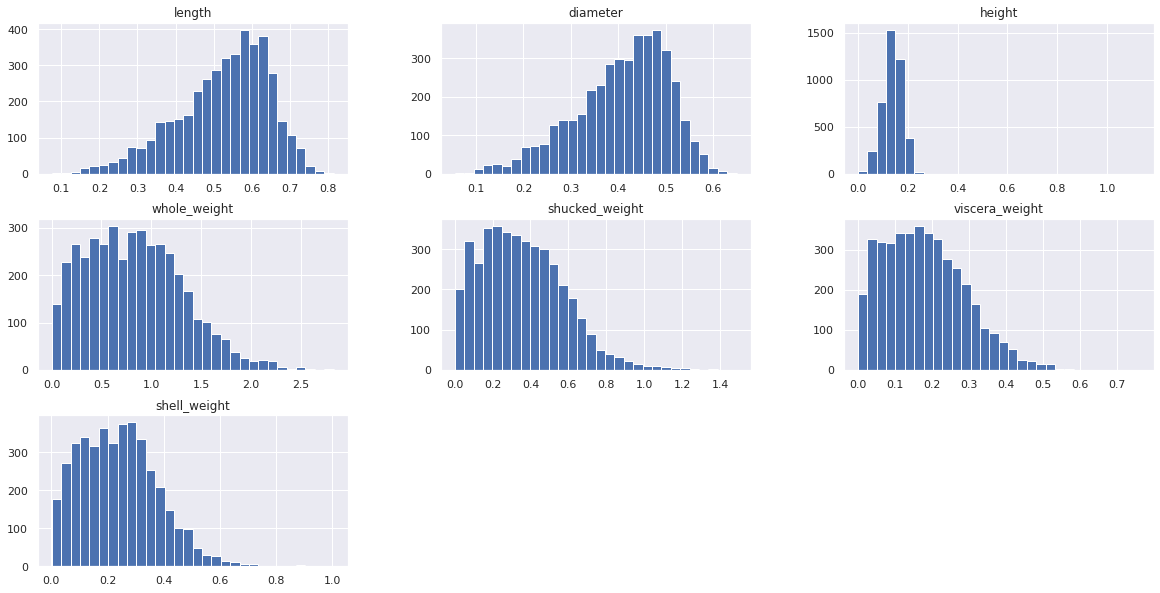

In [192]:
#Histogram
X[num_vars].hist(figsize=(20,10), bins=30)
plt.show()

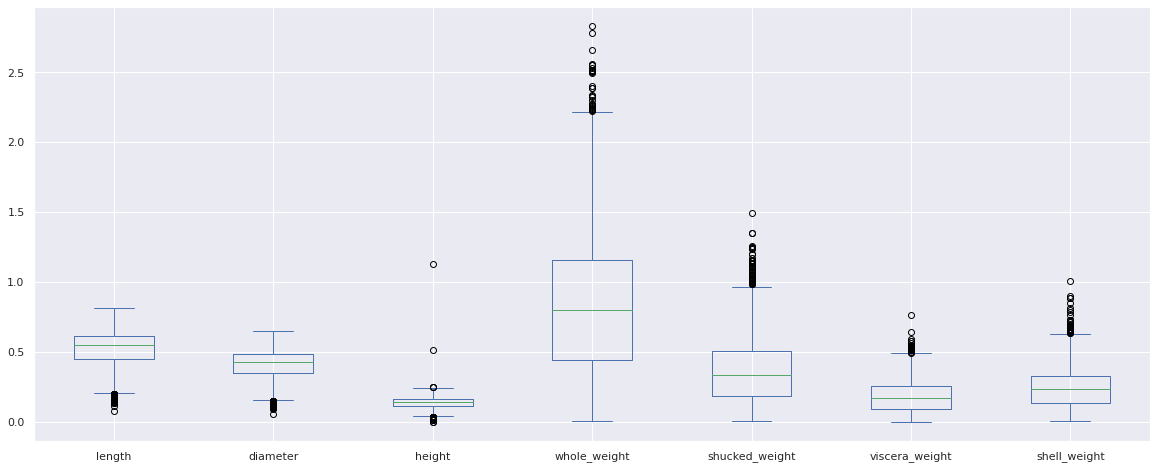

In [193]:
#Boxplot
X[num_vars].plot(kind='box',figsize=(20,8))
plt.show()

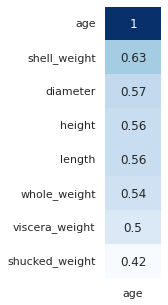

In [194]:
#Correlation btw variables and target
plt.figure(figsize=(1,5))
sns.heatmap(
    data.corr(method='pearson')[['age']].sort_values('age', ascending=False), 
    annot=True, cbar=False, cmap='Blues')
plt.show()

Obeservation :<br>
- Distribution of continuous variables<br>
- Outliers are present in some variables<br>
- height variable outliers should be removed<br>
- shell_weight is the most correlated variable with target

#### 3c.(ii) Categorical variables

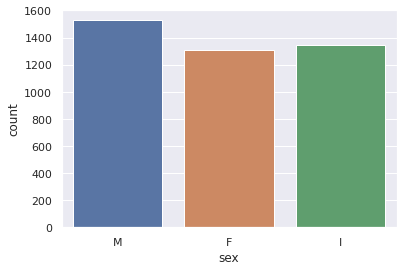

In [195]:
#Countplot
sns.countplot(x = X.sex)
plt.show()

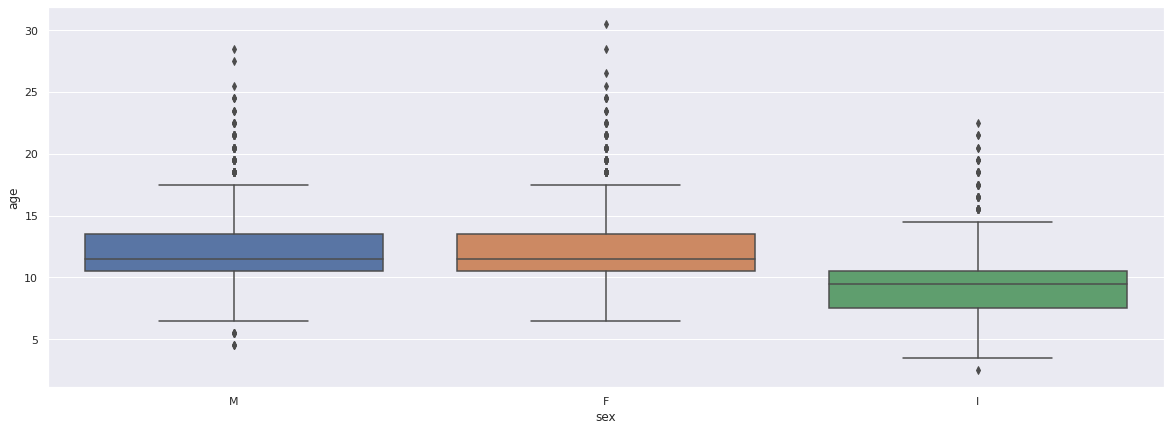

In [196]:
#BoxPlot
plt.figure(figsize=(20,7))
sns.boxplot(data = data, x='sex', y='age')
plt.show()

Observation:

 - Label I(infant) has relatively low maximum age(<25) which is obvious.<br>
 - The oldest abalone is a female

### 3d. Bivariate analysis

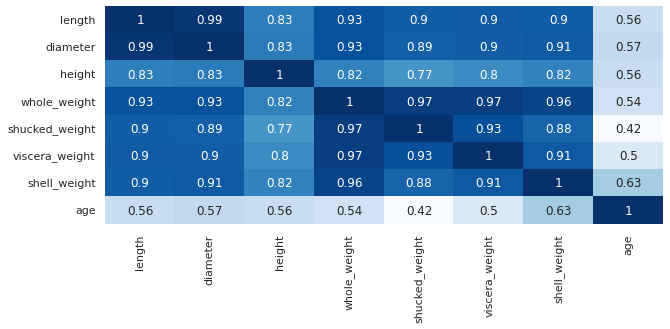

In [197]:
##Correlation with each other
plt.figure(figsize=(10,4)) #Correlation
sns.heatmap(data.corr(method='pearson'), annot=True, cbar=False, cmap='Blues')
plt.show()

Observation:

 - MultiCollinearity exists among variables<br>
 - (diameter, length)  highly correlated

# 4. Feature engineering

### 4a. Handling Categorical variable

- One hot encoding

In [198]:
X = pd.get_dummies(X, drop_first=True)
X.head(3)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,0,0


### // Data Splitting
- Train
- Cross-validation
- Test

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print("No of data points in train set:",X_train.shape[0])
print("No of data points in cross-validation set:",X_cv.shape[0])
print("No of data points in test set:",X_test.shape[0])

No of data points in train set: 2672
No of data points in cross-validation set: 669
No of data points in test set: 836


# 5. Machine Learning


### 5a. Linear model
- Linear regression

In [200]:
tr_err, cv_err, test_err = evaluate(LinearRegression(), X_train, X_cv, X_test, y_train, y_cv, y_test)

model = LinearRegression()

model.fit(X_train, y_train)
y_pr = model.predict(X_test)

print("train error",tr_err)
print("cv error", cv_err)
print("test error", test_err)

train error 2.1751554137317206
cv error 2.3554995969359
test error 2.2204593120587686


### 5b. Non-Linear models

In [201]:
non_linear_models ={'KNeighborsRegressor':KNeighborsRegressor(),
         'DecisionTreeRegressor':DecisionTreeRegressor(random_state=0),
         'RandomForestRegressor':RandomForestRegressor(random_state=0)
        }

In [202]:
df3 = []

for name, model in non_linear_models.items():
    train_error, cv_error, test_error = evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
    
    df3.append([name, train_error, cv_error, test_error])

df3 = pd.DataFrame(df3, columns=['Model', 'Train Error', 'CV Error', 'Test Error']).sort_values('Test Error')
df3

,Model,Train Error,CV Error,Test Error
2,RandomForestRegressor,0.815675,2.151857,2.240103
0,KNeighborsRegressor,1.825095,2.227012,2.262995
1,DecisionTreeRegressor,0.000000,2.900183,3.061569


In [203]:
#Hyperparameter tuning
models_params2 ={'KNeighborsRegressor':{'n_neighbors':[3,5,11,19],
                                        'metric':['euclidean', 'manhattan']
                                       },
                 
                
                'DecisionTreeRegressor':{"max_depth": [3,2, None],
                                         "max_features": np.random.randint(1, 9, 4),
                                         "min_samples_leaf": np.random.randint(1, 9,4),
                                        },
                 
                 

                'RandomForestRegressor':{'max_depth': [3,5,None],
                                         'max_features': np.random.randint(1, 10,5),
                                         'min_samples_leaf': np.random.randint(1, 10,5),
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [10,20,30,40,50,100,200]
                                        }
                }

In [204]:
df4 = []
for model_name in non_linear_models.keys():
    print(model_name)
    model = non_linear_models[model_name]
    params = models_params2[model_name]
    regressor = RandomizedSearchCV(estimator = model,
                                   n_iter=10,
                                   param_distributions = params,
                                   cv = 3,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_jobs=-1)
    
    search = regressor.fit(X_train, y_train)
    model = search.best_estimator_
    
    train_error, cv_error, test_error = evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
    
    df4.append(['best '+model_name, train_error, cv_error, test_error])
    
    print('Best params :',search.best_params_)
    print()
df4 = pd.DataFrame(df4, columns=['Model', 'Train Error', 'CV Error', 'Test Error']).sort_values('CV Error')    
df4

KNeighborsRegressor
Best params : {'n_neighbors': 11, 'metric': 'euclidean'}

DecisionTreeRegressor
Best params : {'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 3}

RandomForestRegressor
Best params : {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 6, 'max_depth': None}



,Model,Train Error,CV Error,Test Error
2,best RandomForestRegressor,1.717089,2.122497,2.217735
0,best KNeighborsRegressor,1.998627,2.161156,2.209284
1,best DecisionTreeRegressor,2.459270,2.417138,2.622243


In [205]:
df = pd.concat([df3,df4]).sort_values('CV Error')
df

,Model,Train Error,CV Error,Test Error
2,best RandomForestRegressor,1.717089,2.122497,2.217735
2,RandomForestRegressor,0.815675,2.151857,2.240103
0,best KNeighborsRegressor,1.998627,2.161156,2.209284
0,KNeighborsRegressor,1.825095,2.227012,2.262995
1,best DecisionTreeRegressor,2.459270,2.417138,2.622243
1,DecisionTreeRegressor,0.000000,2.900183,3.061569


### 5d. Final model

- RandomForestRegressor

In [206]:
final_model = RandomForestRegressor(n_estimators= 200,
                                    min_samples_split= 5,
                                    min_samples_leaf= 7,
                                    max_features= 5, 
                                    max_depth= None,
                                    random_state=0
                                   )
final_model.fit(X_train, y_train)

RandomForestRegressor(max_features=5, min_samples_leaf=7, min_samples_split=5,
                      n_estimators=200, random_state=0)

In [207]:
train_preds = final_model.predict(X_train)
cv_preds = final_model.predict(X_cv)
test_preds = final_model.predict(X_test)

print('Train RMSE',np.sqrt(mean_squared_error(y_train, train_preds)))
print('CV RMSE',np.sqrt(mean_squared_error(y_cv, cv_preds)))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, test_preds)))
print('\nTest predictions:',test_preds[:5])

Train RMSE 1.6802580973193724
CV RMSE 2.1119760596835335
Test RMSE 2.2038810413027137

Test predictions: [13.83485937 10.9797302  16.16323338 12.55751894 14.12479925]


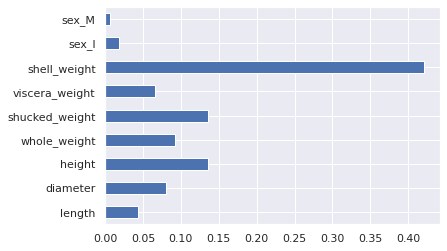

In [208]:
pd.Series(final_model.feature_importances_,index=X_train.columns).plot.barh()
plt.show()

# 6. Saving the final model

In [209]:
f = open('rf_model.pkl', 'wb')
pickle.dump(final_model, f)
f.close()

In [210]:
f = open('rf_model.pkl', 'rb')
model = pickle.load(f)
f.close()

preds = model.predict(X_test)
print('\nTest predictions:',np.round(preds[:5],1))


Test predictions: [13.8 11.  16.2 12.6 14.1]


In [211]:
print('Test original:', y_test[:5].values)

Test original: [10.5  9.5 17.5 10.5 15.5]
